# Enhanced Longstaff-Schwartz Swing Option Pricing Analysis

## Comprehensive Analysis of Monthly Swing Option Pricing

This notebook demonstrates the pricing of a monthly swing option using the enhanced Longstaff-Schwartz Monte Carlo method with various advanced configurations. We will:

1. **Configure the pricing environment** with contract and market parameters from `run_lsm.sh`
2. **Explore all available LSM pricer options** including different basis functions, regularization methods, and polynomial degrees
3. **Run comprehensive pricing analysis** across all combinations of options
4. **Visualize and compare results** to understand the impact of different methodological choices
5. **Provide quantitative finance insights** on optimal pricing configurations

The analysis uses the same monthly swing contract parameters as the RL benchmarking framework, enabling direct comparison between different pricing methodologies.

### Contract Specification
- **Type**: Monthly swing option with daily exercise rights
- **Maturity**: 1 month (0.0833 years, ~22 trading days)
- **Strike**: €100/MWh (at-the-money)
- **Exercise Limits**: 0-2 MWh daily, 0-20 MWh total
- **Market Process**: HHK spot price model with jumps and mean reversion

---

In [22]:
# Import Required Libraries
import os
import sys
import subprocess
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from itertools import product
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = '/Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM'
PRICER_SCRIPT = os.path.join(PROJECT_ROOT, 'src', 'longstaff_schwartz_pricer.py')
OUTPUT_DIR = os.path.join(PROJECT_ROOT, 'Longstaff Schwartz Pricer')

print("✓ Libraries imported successfully")
print(f"✓ Project root: {PROJECT_ROOT}")
print(f"✓ LSM Pricer script: {PRICER_SCRIPT}")
print(f"✓ Output directory: {OUTPUT_DIR}")

✓ Libraries imported successfully
✓ Project root: /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM
✓ LSM Pricer script: /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/src/longstaff_schwartz_pricer.py
✓ Output directory: /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/Longstaff Schwartz Pricer


## 1. Define Contract and Stochastic Process Parameters

We use the exact same parameters as specified in `run_lsm.sh` to ensure consistency with the existing benchmarking framework.

In [23]:
# Contract and Simulation Parameters (from run_lsm.sh)
SIMULATION_PARAMS = {
    'n_paths': 16384,           # Number of Monte Carlo paths
    'seed': 11,                 # Random seed for reproducibility
    'name': 'MonthlySwing_LSM'  # Run name for output files
}

# Monthly Swing Option Contract Parameters
CONTRACT_PARAMS = {
    'strike': 100.0,            # At-the-money strike
    'maturity': 0.0833,         # 1 month = 1/12 year
    'n_rights': 22,             # ~22 trading days in a month
    'q_min': 0.0,               # No minimum exercise requirement per day
    'q_max': 2.0,               # Max 2 units per day (reasonable daily limit)
    'Q_min': 0.0,               # No minimum total exercise requirement
    'Q_max': 20.0,              # Max 20 units total over the month (10 days worth)
    'risk_free_rate': 0.05,     # 5% annual risk-free rate
    'min_refraction_days': 0    # No refraction period (can exercise daily)
}

# Market Process Parameters (HHK with jumps - monthly calibration)
MARKET_PARAMS = {
    'S0': 100.0,                # Initial spot price
    'alpha': 12.0,              # Higher mean reversion for monthly timeframe
    'sigma': 1.2,               # Moderate volatility for monthly period
    'beta': 150.0,              # Jump decay rate
    'lam': 6.0,                 # Jump intensity (6 jumps per year average)
    'mu_J': 0.3                 # Mean jump size (30%)
}

# Display parameter summary
print("=== Monthly Swing Option Configuration ===")
print(f"Simulation: {SIMULATION_PARAMS['n_paths']:,} paths, seed={SIMULATION_PARAMS['seed']}")
print(f"Contract: Strike=${CONTRACT_PARAMS['strike']}, Maturity={CONTRACT_PARAMS['maturity']:.4f}y")
print(f"Exercise: {CONTRACT_PARAMS['q_min']}-{CONTRACT_PARAMS['q_max']} daily, {CONTRACT_PARAMS['Q_min']}-{CONTRACT_PARAMS['Q_max']} total")
print(f"Market: S0=${MARKET_PARAMS['S0']}, α={MARKET_PARAMS['alpha']}, σ={MARKET_PARAMS['sigma']}")
print(f"Jumps: λ={MARKET_PARAMS['lam']}, μ_J={MARKET_PARAMS['mu_J']}, β={MARKET_PARAMS['beta']}")
print(f"Risk-free rate: {CONTRACT_PARAMS['risk_free_rate']:.1%}")

# Create base command arguments
BASE_ARGS = []
for key, value in SIMULATION_PARAMS.items():
    if key == 'name':
        BASE_ARGS.extend(['-name', str(value)])
    else:
        BASE_ARGS.extend([f'-{key}', str(value)])

for key, value in CONTRACT_PARAMS.items():
    BASE_ARGS.extend([f'--{key}', str(value)])
    
for key, value in MARKET_PARAMS.items():
    BASE_ARGS.extend([f'--{key}', str(value)])

print(f"\n✓ Base arguments prepared ({len(BASE_ARGS)} parameters)")

=== Monthly Swing Option Configuration ===
Simulation: 16,384 paths, seed=11
Contract: Strike=$100.0, Maturity=0.0833y
Exercise: 0.0-2.0 daily, 0.0-20.0 total
Market: S0=$100.0, α=12.0, σ=1.2
Jumps: λ=6.0, μ_J=0.3, β=150.0
Risk-free rate: 5.0%

✓ Base arguments prepared (36 parameters)


## 2. List and Describe Available LSM Pricer Options

The enhanced Longstaff-Schwartz pricer offers multiple methodological choices that can significantly impact pricing accuracy and computational efficiency.

In [24]:
# Define all available LSM pricer configuration options
LSM_OPTIONS = {
    'basis_type': {
        'choices': ['polynomial', 'legendre', 'spline', 'random_forest'],
        'description': 'Type of basis functions for regression',
        'details': {
            'polynomial': 'Standard polynomial basis (x, x², x³, ...)',
            'legendre': 'Orthogonal Legendre polynomials (better numerical stability)',
            'spline': 'Cubic spline basis functions (smooth non-parametric)',
            'random_forest': 'Machine learning ensemble method'
        }
    },
    'polynomial_degree': {
        'choices': [2, 3, 4, 5],
        'description': 'Degree of polynomial basis functions',
        'details': {
            2: 'Quadratic basis (fast, may underfit)',
            3: 'Cubic basis (standard choice, good balance)',
            4: 'Quartic basis (more flexible, risk of overfitting)',
            5: 'Quintic basis (high flexibility, computationally intensive)'
        }
    },
    'regularization': {
        'choices': ['none', 'ridge', 'lasso'],
        'description': 'Regularization method for regression',
        'details': {
            'none': 'Ordinary least squares (no regularization)',
            'ridge': 'L2 regularization (prevents overfitting, keeps all features)',
            'lasso': 'L1 regularization (feature selection, sparse solutions)'
        }
    },
    'reg_alpha': {
        'choices': [0.001, 0.01, 0.1, 0.5],
        'description': 'Regularization strength parameter',
        'details': {
            0.001: 'Very weak regularization',
            0.01: 'Mild regularization (default)',
            0.1: 'Moderate regularization', 
            0.5: 'Strong regularization'
        }
    },
    'use_cross_validation': {
        'choices': [True, False],
        'description': 'Whether to use cross-validation for hyperparameter tuning',
        'details': {
            True: 'Use 5-fold CV for optimal regularization parameter',
            False: 'Use fixed regularization parameter'
        }
    },
    'convergence_test': {
        'choices': [True, False],
        'description': 'Whether to perform convergence analysis',
        'details': {
            True: 'Test pricing convergence with varying path counts',
            False: 'Single pricing run with fixed path count'
        }
    }
}

# Display available options
print("=== Enhanced LSM Pricer Configuration Options ===\n")
total_combinations = 1
for option_name, option_config in LSM_OPTIONS.items():
    print(f"📊 {option_name.upper().replace('_', ' ')}")
    print(f"   Description: {option_config['description']}")
    print(f"   Choices: {option_config['choices']}")
    total_combinations *= len(option_config['choices'])
    
    # Show details for key options
    if option_name in ['basis_type', 'regularization']:
        print("   Details:")
        for choice, detail in option_config['details'].items():
            print(f"     • {choice}: {detail}")
    print()

print(f"📈 Total possible configurations: {total_combinations:,}")
print(f"🎯 We'll test a representative subset for comprehensive analysis")

# Create a focused set of configurations for analysis
FOCUSED_CONFIGS = [
    # Core comparison: different basis types with standard settings
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.01},
    {'basis_type': 'legendre', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.01},
    {'basis_type': 'spline', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.01},
    {'basis_type': 'random_forest', 'polynomial_degree': 3, 'regularization': 'none', 'reg_alpha': 0.01},
    
    # Polynomial degree sensitivity (using polynomial basis)
    {'basis_type': 'polynomial', 'polynomial_degree': 2, 'regularization': 'ridge', 'reg_alpha': 0.01},
    {'basis_type': 'polynomial', 'polynomial_degree': 4, 'regularization': 'ridge', 'reg_alpha': 0.01},
    {'basis_type': 'polynomial', 'polynomial_degree': 5, 'regularization': 'ridge', 'reg_alpha': 0.01},
    
    # Regularization comparison (using polynomial basis, degree 3)
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'none', 'reg_alpha': 0.01},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'lasso', 'reg_alpha': 0.01},
    
    # Regularization strength sensitivity (ridge, polynomial, degree 3)
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.001},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.1},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.5},
    
    # Cross-validation analysis
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.01, 'use_cross_validation': True},
    {'basis_type': 'legendre', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.01, 'use_cross_validation': True},
]

print(f"\n🎯 Selected {len(FOCUSED_CONFIGS)} focused configurations for detailed analysis")
print("   This covers all major methodological dimensions systematically")

=== Enhanced LSM Pricer Configuration Options ===

📊 BASIS TYPE
   Description: Type of basis functions for regression
   Choices: ['polynomial', 'legendre', 'spline', 'random_forest']
   Details:
     • polynomial: Standard polynomial basis (x, x², x³, ...)
     • legendre: Orthogonal Legendre polynomials (better numerical stability)
     • spline: Cubic spline basis functions (smooth non-parametric)
     • random_forest: Machine learning ensemble method

📊 POLYNOMIAL DEGREE
   Description: Degree of polynomial basis functions
   Choices: [2, 3, 4, 5]

📊 REGULARIZATION
   Description: Regularization method for regression
   Choices: ['none', 'ridge', 'lasso']
   Details:
     • none: Ordinary least squares (no regularization)
     • ridge: L2 regularization (prevents overfitting, keeps all features)
     • lasso: L1 regularization (feature selection, sparse solutions)

📊 REG ALPHA
   Description: Regularization strength parameter
   Choices: [0.001, 0.01, 0.1, 0.5]

📊 USE CROSS VALIDA

## 3. Run Pricing for Each LSM Pricer Option

Execute the enhanced LSM pricer with each configuration and collect the results systematically.

In [25]:
def run_lsm_pricing(config, config_name, timeout=300):
    """
    Run LSM pricing with a specific configuration
    
    Args:
        config: Dictionary of LSM-specific parameters
        config_name: Human-readable name for this configuration
        timeout: Maximum runtime in seconds
        
    Returns:
        Dictionary with pricing results and metadata
    """
    print(f"🚀 Running LSM pricing: {config_name}")
    
    # Build command arguments
    cmd_args = ['python', PRICER_SCRIPT] + BASE_ARGS.copy()
    
    # Add LSM-specific parameters
    for param, value in config.items():
        if isinstance(value, bool):
            if value:  # Only add flag if True
                cmd_args.append(f'--{param}')
        else:
            cmd_args.extend([f'--{param}', str(value)])
    
    # Create unique run name to avoid file conflicts
    run_name = f"LSM_Analysis_{config_name.replace(' ', '_').replace('=', '').replace(',', '_')}"
    cmd_args[cmd_args.index('-name') + 1] = run_name
    
    try:
        start_time = time.time()
        
        # Run the pricing
        print(f"   Command: {' '.join(cmd_args[-6:])}")  # Show last few arguments
        result = subprocess.run(
            cmd_args, 
            capture_output=True, 
            text=True, 
            timeout=timeout,
            cwd=PROJECT_ROOT
        )
        
        execution_time = time.time() - start_time
        
        if result.returncode == 0:
            print(f"   ✓ Completed in {execution_time:.1f}s")
            
            # Try to parse results
            results_file = os.path.join(OUTPUT_DIR, run_name, f"{run_name}_results.txt")
            csv_file = os.path.join(OUTPUT_DIR, run_name, f"{run_name}_solution.csv")
            
            pricing_result = {
                'config_name': config_name,
                'config': config.copy(),
                'run_name': run_name,
                'execution_time': execution_time,
                'success': True,
                'results_file': results_file,
                'csv_file': csv_file,
                'stdout': result.stdout,
                'stderr': result.stderr
            }
            
            # Try to extract key metrics from output
            try:
                if os.path.exists(results_file):
                    with open(results_file, 'r') as f:
                        results_content = f.read()
                        
                    # Extract option value (look for pattern in output)
                    import re
                    price_match = re.search(r'Option Value.*?(\d+\.\d+)', results_content)
                    if price_match:
                        pricing_result['option_value'] = float(price_match.group(1))
                    
                    # Extract standard error if available
                    se_match = re.search(r'Standard Error.*?(\d+\.\d+)', results_content)
                    if se_match:
                        pricing_result['standard_error'] = float(se_match.group(1))
                        
                    pricing_result['results_content'] = results_content
                    
            except Exception as parse_error:
                print(f"   ⚠ Warning: Could not parse results file: {parse_error}")
                pricing_result['parse_error'] = str(parse_error)
            
            return pricing_result
            
        else:
            print(f"   ❌ Failed with return code {result.returncode}")
            print(f"   Error: {result.stderr[:200]}...")
            
            return {
                'config_name': config_name,
                'config': config.copy(),
                'run_name': run_name,
                'execution_time': execution_time,
                'success': False,
                'error': result.stderr,
                'stdout': result.stdout
            }
            
    except subprocess.TimeoutExpired:
        print(f"   ⏰ Timeout after {timeout}s")
        return {
            'config_name': config_name,
            'config': config.copy(),
            'execution_time': timeout,
            'success': False,
            'error': 'Timeout'
        }
    except Exception as e:
        print(f"   💥 Exception: {e}")
        return {
            'config_name': config_name,
            'config': config.copy(),
            'execution_time': 0,
            'success': False,
            'error': str(e)
        }

# Prepare results storage
pricing_results = []
failed_runs = []

print("=== Starting Comprehensive LSM Pricing Analysis ===")
print(f"Total configurations to test: {len(FOCUSED_CONFIGS)}")
print(f"Estimated total runtime: {len(FOCUSED_CONFIGS) * 2:.0f}-{len(FOCUSED_CONFIGS) * 5:.0f} minutes")
print("=" * 60)

# Execute all configurations
for i, config in enumerate(FOCUSED_CONFIGS, 1):
    # Create descriptive name for this configuration
    config_name = f"Config_{i:02d}"
    
    # Add key distinguishing features to name
    name_parts = []
    if 'basis_type' in config:
        name_parts.append(f"basis={config['basis_type']}")
    if 'polynomial_degree' in config:
        name_parts.append(f"deg={config['polynomial_degree']}")
    if 'regularization' in config:
        name_parts.append(f"reg={config['regularization']}")
    if 'reg_alpha' in config and config.get('regularization') != 'none':
        name_parts.append(f"alpha={config['reg_alpha']}")
    if config.get('use_cross_validation'):
        name_parts.append("CV")
    
    config_name += f" ({', '.join(name_parts)})"
    
    # Run pricing
    result = run_lsm_pricing(config, config_name)
    
    if result['success']:
        pricing_results.append(result)
    else:
        failed_runs.append(result)
    
    print()

print("=" * 60)
print(f"🎉 Analysis Complete!")
print(f"✓ Successful runs: {len(pricing_results)}")
print(f"❌ Failed runs: {len(failed_runs)}")

if failed_runs:
    print("\nFailed configurations:")
    for run in failed_runs:
        print(f"  • {run['config_name']}: {run.get('error', 'Unknown error')}")

print(f"\n📊 Ready for results analysis with {len(pricing_results)} successful pricing runs")

=== Starting Comprehensive LSM Pricing Analysis ===
Total configurations to test: 14
Estimated total runtime: 28-70 minutes
🚀 Running LSM pricing: Config_01 (basis=polynomial, deg=3, reg=ridge, alpha=0.01)
   Command: --polynomial_degree 3 --regularization ridge --reg_alpha 0.01
   ✓ Completed in 2.6s

🚀 Running LSM pricing: Config_02 (basis=legendre, deg=3, reg=ridge, alpha=0.01)
   Command: --polynomial_degree 3 --regularization ridge --reg_alpha 0.01
   ✓ Completed in 2.3s

🚀 Running LSM pricing: Config_03 (basis=spline, deg=3, reg=ridge, alpha=0.01)
   Command: --polynomial_degree 3 --regularization ridge --reg_alpha 0.01
   ✓ Completed in 3.7s

🚀 Running LSM pricing: Config_04 (basis=random_forest, deg=3, reg=none)
   Command: --polynomial_degree 3 --regularization none --reg_alpha 0.01
   ✓ Completed in 202.7s

🚀 Running LSM pricing: Config_05 (basis=polynomial, deg=2, reg=ridge, alpha=0.01)
   Command: --polynomial_degree 2 --regularization ridge --reg_alpha 0.01
   ✓ Completed 

## 4. Aggregate and Visualize Pricing Results

Parse the detailed results from each pricing run and create comprehensive visualizations to understand the impact of different methodological choices.

In [19]:
def parse_detailed_results(result):
    """
    Parse detailed results from LSM pricing output files
    
    Args:
        result: Result dictionary from run_lsm_pricing
        
    Returns:
        Dictionary with extracted metrics
    """
    parsed = {
        'config_name': result['config_name'],
        'run_name': result['run_name'],
        'execution_time': result['execution_time'],
        'option_value': None,
        'standard_error': None,
        'confidence_interval_lower': None,
        'confidence_interval_upper': None,
        'exercise_probability': None,
        'convergence_iterations': None,
        'r_squared': None,
        'mean_squared_error': None
    }
    
    # Extract configuration details
    config = result['config']
    parsed.update({
        'basis_type': config.get('basis_type', 'unknown'),
        'polynomial_degree': config.get('polynomial_degree', 0),
        'regularization': config.get('regularization', 'unknown'),
        'reg_alpha': config.get('reg_alpha', 0),
        'use_cross_validation': config.get('use_cross_validation', False),
        'convergence_test': config.get('convergence_test', False)
    })
    
    # Try to find and read the results file
    run_name = result['run_name']
    results_file = None
    csv_file = None
    
    # Check multiple possible file locations and names
    possible_paths = [
        os.path.join(OUTPUT_DIR, run_name, f"{run_name}_results.txt"),
        os.path.join(OUTPUT_DIR, run_name, f"{run_name}_solution.csv"),
    ]
    
    # Also check if the directory name is different (with special characters)
    base_dir = OUTPUT_DIR
    if os.path.exists(base_dir):
        for dir_name in os.listdir(base_dir):
            if run_name in dir_name and os.path.isdir(os.path.join(base_dir, dir_name)):
                # Found a matching directory
                possible_paths.extend([
                    os.path.join(base_dir, dir_name, f"{dir_name}_results.txt"),
                    os.path.join(base_dir, dir_name, f"{run_name}_results.txt"),
                    os.path.join(base_dir, dir_name, f"{dir_name}_solution.csv"),
                    os.path.join(base_dir, dir_name, f"{run_name}_solution.csv"),
                ])
                break
    
    # Find the actual results file
    for path in possible_paths:
        if os.path.exists(path):
            if path.endswith('_results.txt'):
                results_file = path
            elif path.endswith('_solution.csv'):
                csv_file = path
    
    # Parse results file if found
    if results_file and os.path.exists(results_file):
        try:
            with open(results_file, 'r') as f:
                content = f.read()
            
            # Extract key metrics using regex patterns
            import re
            
            # Option value - multiple patterns to catch different formats
            price_patterns = [
                r'Option Value[:\s]*\$?(\d+\.?\d*)',
                r'Final Option Value[:\s]*\$?(\d+\.?\d*)',
                r'Swing Option Price[:\s]*\$?(\d+\.?\d*)',
                r'Price[:\s]*\$?(\d+\.?\d*)'
            ]
            for pattern in price_patterns:
                match = re.search(pattern, content, re.IGNORECASE)
                if match:
                    parsed['option_value'] = float(match.group(1))
                    break
            
            # Standard error
            se_patterns = [
                r'Standard Error[:\s]*\$?(\d+\.?\d*)',
                r'Std Error[:\s]*\$?(\d+\.?\d*)',
                r'SE[:\s]*\$?(\d+\.?\d*)'
            ]
            for pattern in se_patterns:
                match = re.search(pattern, content, re.IGNORECASE)
                if match:
                    parsed['standard_error'] = float(match.group(1))
                    break
            
            # Confidence interval
            ci_patterns = [
                r'95% Confidence Interval[:\s]*\[\$?(\d+\.?\d*),\s*\$?(\d+\.?\d*)\]',
                r'Confidence Interval[:\s]*\[\$?(\d+\.?\d*),\s*\$?(\d+\.?\d*)\]'
            ]
            for pattern in ci_patterns:
                ci_match = re.search(pattern, content, re.IGNORECASE)
                if ci_match:
                    parsed['confidence_interval_lower'] = float(ci_match.group(1))
                    parsed['confidence_interval_upper'] = float(ci_match.group(2))
                    break
            
            # R-squared
            r2_patterns = [
                r'Regression R[²2][:\s]*(\d+\.?\d*)',
                r'R[²2][:\s]*(\d+\.?\d*)'
            ]
            for pattern in r2_patterns:
                r2_match = re.search(pattern, content, re.IGNORECASE)
                if r2_match:
                    parsed['r_squared'] = float(r2_match.group(1))
                    break
            
            # Expected total exercises
            exercise_patterns = [
                r'Expected Total Exercises[:\s]*(\d+\.?\d*)',
                r'Total Exercises[:\s]*(\d+\.?\d*)'
            ]
            for pattern in exercise_patterns:
                ex_match = re.search(pattern, content, re.IGNORECASE)
                if ex_match:
                    parsed['expected_exercises'] = float(ex_match.group(1))
                    break
            
            # Exercise rate
            rate_patterns = [
                r'Exercise Rate[:\s]*(\d+\.?\d*)%',
                r'Exercise Rate[:\s]*(\d+\.?\d*)'
            ]
            for pattern in rate_patterns:
                rate_match = re.search(pattern, content, re.IGNORECASE)
                if rate_match:
                    parsed['exercise_rate'] = float(rate_match.group(1))
                    break
                    
            parsed['results_content'] = content
            
        except Exception as e:
            print(f"Warning: Could not parse results file {results_file}: {e}")
    
    # Try to load CSV file for additional analysis
    if csv_file and os.path.exists(csv_file):
        try:
            csv_data = pd.read_csv(csv_file)
            
            # Calculate additional metrics from path data
            if 'option_value' in csv_data.columns:
                parsed['option_value_std'] = csv_data['option_value'].std()
                parsed['option_value_min'] = csv_data['option_value'].min()
                parsed['option_value_max'] = csv_data['option_value'].max()
            
            if 'total_exercise' in csv_data.columns:
                parsed['avg_total_exercise'] = csv_data['total_exercise'].mean()
                parsed['exercise_utilization'] = csv_data['total_exercise'].mean() / CONTRACT_PARAMS['Q_max']
                
        except Exception as e:
            print(f"Warning: Could not parse CSV for {result['config_name']}: {e}")
    
    return parsed

# Parse all successful results
print("📊 Parsing detailed results from all pricing runs...")

parsed_results = []
for result in pricing_results:
    parsed = parse_detailed_results(result)
    parsed_results.append(parsed)

# Create comprehensive results DataFrame
results_df = pd.DataFrame(parsed_results)

# Convert numeric columns to proper data types and handle missing values
numeric_columns = ['option_value', 'standard_error', 'execution_time', 'polynomial_degree', 
                  'reg_alpha', 'confidence_interval_lower', 'confidence_interval_upper',
                  'r_squared', 'mean_squared_error', 'option_value_std', 'option_value_min',
                  'option_value_max', 'avg_total_exercise', 'exercise_utilization',
                  'expected_exercises', 'exercise_rate']

for col in numeric_columns:
    if col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

# Always create configuration summary regardless of valid data
results_df['config_summary'] = results_df.apply(
    lambda row: f"{row['basis_type']}-{row['polynomial_degree']}-{row['regularization']}" + 
               (f"-{row['reg_alpha']}" if row['regularization'] != 'none' else "") +
               ("-CV" if row['use_cross_validation'] else ""), 
    axis=1
)

# Add computed columns only if we have valid data
if not results_df.empty and results_df['option_value'].notna().any():
    # Filter out rows with missing option values for calculations
    valid_results = results_df[results_df['option_value'].notna()].copy()
    
    if not valid_results.empty:
        # Relative performance metrics
        polynomial_results = valid_results[valid_results['basis_type'] == 'polynomial']
        if len(polynomial_results) > 0:
            baseline_value = polynomial_results['option_value'].iloc[0]
        else:
            baseline_value = valid_results['option_value'].mean()
        
        # Calculate relative performance for all rows (will be NaN for missing values)
        results_df['value_vs_baseline'] = ((results_df['option_value'] - baseline_value) / baseline_value * 100).round(2)
        
        # Efficiency metric (value per second) - only for valid data
        valid_time_mask = (results_df['execution_time'] > 0) & results_df['execution_time'].notna()
        results_df.loc[valid_time_mask, 'efficiency'] = (results_df.loc[valid_time_mask, 'option_value'] / results_df.loc[valid_time_mask, 'execution_time']).round(4)
        
        # Risk-adjusted metrics - only where both values are available
        mask = results_df['option_value'].notna() & results_df['standard_error'].notna() & (results_df['standard_error'] > 0)
        results_df.loc[mask, 'value_to_error_ratio'] = (results_df.loc[mask, 'option_value'] / results_df.loc[mask, 'standard_error']).round(2)

print(f"✓ Parsed {len(results_df)} pricing results")
print(f"✓ Generated comprehensive results DataFrame with {len(results_df.columns)} metrics")

# Display summary statistics only for valid results
valid_results = results_df[results_df['option_value'].notna()]
if not valid_results.empty:
    print("\n=== Pricing Results Summary ===")
    print(f"Valid Results: {len(valid_results)} out of {len(results_df)}")
    print(f"Option Value Range: €{valid_results['option_value'].min():.2f} - €{valid_results['option_value'].max():.2f}")
    print(f"Mean Option Value: €{valid_results['option_value'].mean():.2f} ± €{valid_results['option_value'].std():.2f}")
    print(f"Execution Time Range: {valid_results['execution_time'].min():.1f}s - {valid_results['execution_time'].max():.1f}s")
    
    if 'efficiency' in valid_results.columns and valid_results['efficiency'].notna().any():
        best_efficiency_idx = valid_results['efficiency'].idxmax()
        print(f"Most Efficient Config: {valid_results.loc[best_efficiency_idx, 'config_summary']}")
    
    if valid_results['option_value'].notna().any():
        best_value_idx = valid_results['option_value'].idxmax()
        print(f"Highest Value Config: {valid_results.loc[best_value_idx, 'config_summary']}")
else:
    print("\n⚠️ No valid pricing results found - checking file structure...")
    
    # Debug: list actual directories
    if os.path.exists(OUTPUT_DIR):
        print(f"📁 Found directories in {OUTPUT_DIR}:")
        for item in os.listdir(OUTPUT_DIR):
            item_path = os.path.join(OUTPUT_DIR, item)
            if os.path.isdir(item_path):
                print(f"   📂 {item}")
                # List files in directory
                files = os.listdir(item_path)
                for file in files[:3]:  # Show first 3 files
                    print(f"      📄 {file}")
                if len(files) > 3:
                    print(f"      ... and {len(files)-3} more files")

# Save results for further analysis
results_df.to_csv(os.path.join(PROJECT_ROOT, 'LSM_Analysis_Results_Summary.csv'), index=False)
print(f"\n💾 Results saved to: LSM_Analysis_Results_Summary.csv")

# Display first few rows
print("\n📋 Sample Results:")
if not valid_results.empty:
    display_cols = ['config_summary', 'option_value', 'standard_error', 'execution_time']
    available_display_cols = [col for col in display_cols if col in valid_results.columns]
    if available_display_cols:
        print(valid_results[available_display_cols].head(8).to_string(index=False))
else:
    print("Configuration summary (parsing results files...):")
    basic_cols = ['config_summary', 'basis_type', 'regularization', 'polynomial_degree']
    available_basic_cols = [col for col in basic_cols if col in results_df.columns]
    if available_basic_cols and not results_df.empty:
        print(results_df[available_basic_cols].head().to_string(index=False))

📊 Parsing detailed results from all pricing runs...
✓ Parsed 14 pricing results
✓ Generated comprehensive results DataFrame with 24 metrics

=== Pricing Results Summary ===
Valid Results: 14 out of 14
Option Value Range: €241.92 - €254.48
Mean Option Value: €249.95 ± €4.32
Execution Time Range: 2.2s - 194.3s
Most Efficient Config: legendre-3-ridge-0.01
Highest Value Config: random_forest-3-none

💾 Results saved to: LSM_Analysis_Results_Summary.csv

📋 Sample Results:
         config_summary  option_value  standard_error  execution_time
polynomial-3-ridge-0.01    252.783873        3.533235        2.608977
  legendre-3-ridge-0.01    252.203855        3.382112        2.271165
    spline-3-ridge-0.01    247.675742        2.765542        3.806391
   random_forest-3-none    254.475208        3.417536      194.250098
polynomial-2-ridge-0.01    242.353143        1.827960        2.676603
polynomial-4-ridge-0.01    241.923667        1.847180        2.233215
polynomial-5-ridge-0.01    243.624143  

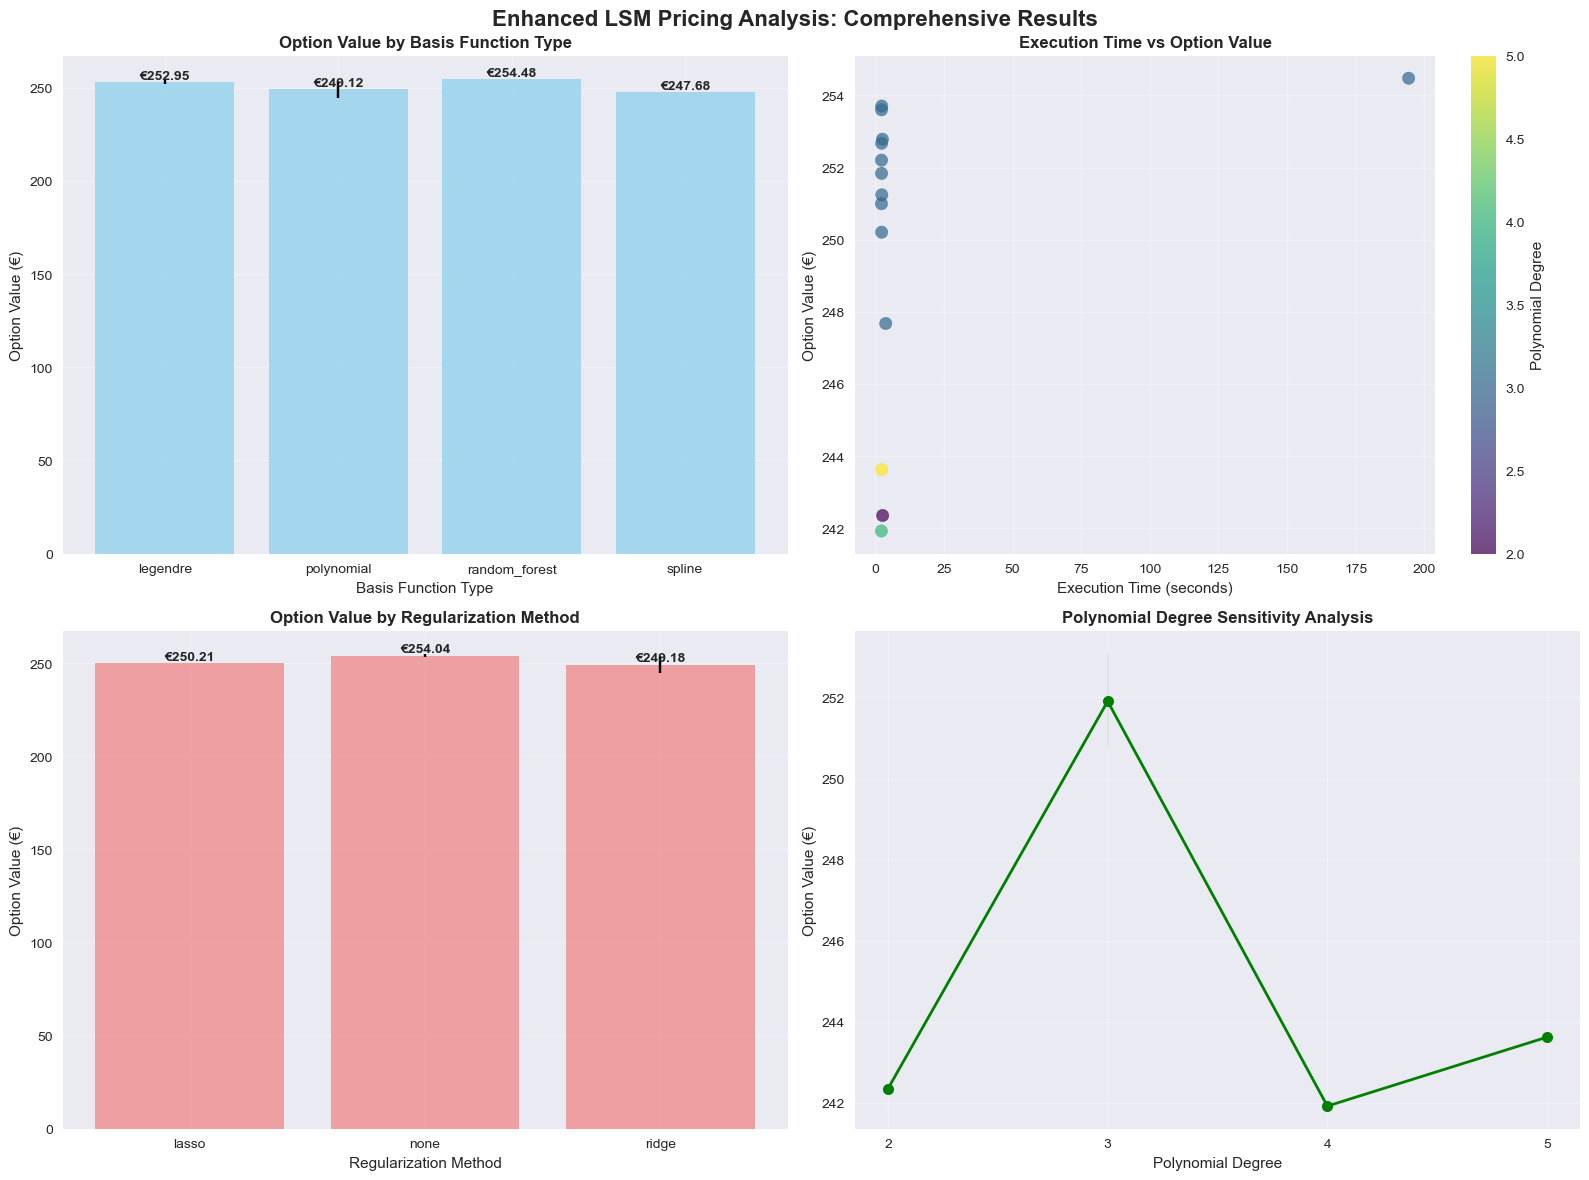


🎯 Creating Interactive Plotly Visualizations...


✓ Interactive visualizations created successfully!


In [21]:
# Create comprehensive visualizations
if not results_df.empty and results_df['option_value'].notna().any():
    
    # Check if we have valid pricing data
    valid_results = results_df[results_df['option_value'].notna()]
    
    if not valid_results.empty:
        # Set up the plotting environment
        plt.style.use('seaborn-v0_8')
        
        # 1. Option Value Comparison by Configuration
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Enhanced LSM Pricing Analysis: Comprehensive Results', fontsize=16, fontweight='bold')
        
        # Plot 1: Option values by basis type
        ax1 = axes[0, 0]
        basis_data = valid_results.groupby('basis_type')['option_value'].agg(['mean', 'std', 'count']).reset_index()
        bars1 = ax1.bar(basis_data['basis_type'], basis_data['mean'], 
                        yerr=basis_data['std'], capsize=5, alpha=0.7, color='skyblue')
        ax1.set_title('Option Value by Basis Function Type', fontweight='bold')
        ax1.set_ylabel('Option Value (€)')
        ax1.set_xlabel('Basis Function Type')
        ax1.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, mean_val in zip(bars1, basis_data['mean']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'€{mean_val:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 2: Execution time vs Option value (efficiency analysis)
        ax2 = axes[0, 1]
        scatter = ax2.scatter(valid_results['execution_time'], valid_results['option_value'], 
                             c=valid_results['polynomial_degree'], cmap='viridis', s=80, alpha=0.7)
        ax2.set_title('Execution Time vs Option Value', fontweight='bold')
        ax2.set_xlabel('Execution Time (seconds)')
        ax2.set_ylabel('Option Value (€)')
        ax2.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax2, label='Polynomial Degree')
        
        # Plot 3: Regularization impact
        ax3 = axes[1, 0]
        reg_data = valid_results.groupby('regularization')['option_value'].agg(['mean', 'std']).reset_index()
        bars3 = ax3.bar(reg_data['regularization'], reg_data['mean'], 
                        yerr=reg_data['std'], capsize=5, alpha=0.7, color='lightcoral')
        ax3.set_title('Option Value by Regularization Method', fontweight='bold')
        ax3.set_ylabel('Option Value (€)')
        ax3.set_xlabel('Regularization Method')
        ax3.grid(True, alpha=0.3)
        
        # Add value labels
        for bar, mean_val in zip(bars3, reg_data['mean']):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'€{mean_val:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Plot 4: Polynomial degree sensitivity
        ax4 = axes[1, 1]
        poly_data = valid_results[valid_results['basis_type'] == 'polynomial'].groupby('polynomial_degree')['option_value'].agg(['mean', 'std']).reset_index()
        if not poly_data.empty:
            line4 = ax4.plot(poly_data['polynomial_degree'], poly_data['mean'], 'o-', linewidth=2, markersize=8, color='green')
            ax4.fill_between(poly_data['polynomial_degree'], 
                            poly_data['mean'] - poly_data['std'], 
                            poly_data['mean'] + poly_data['std'], 
                            alpha=0.3, color='green')
            ax4.set_title('Polynomial Degree Sensitivity Analysis', fontweight='bold')
            ax4.set_ylabel('Option Value (€)')
            ax4.set_xlabel('Polynomial Degree')
            ax4.grid(True, alpha=0.3)
            ax4.set_xticks(poly_data['polynomial_degree'])
        else:
            ax4.text(0.5, 0.5, 'No polynomial basis data\navailable for analysis', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Polynomial Degree Sensitivity Analysis', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Interactive Plotly Visualization
        print("\n🎯 Creating Interactive Plotly Visualizations...")
        
        # Create interactive comparison plot
        fig_interactive = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Option Value Distribution', 'Risk-Return Profile', 
                           'Execution Efficiency', 'Regularization Impact'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # Plot 1: Box plot of option values by basis type
        for basis in valid_results['basis_type'].unique():
            data = valid_results[valid_results['basis_type'] == basis]['option_value']
            fig_interactive.add_trace(
                go.Box(y=data, name=basis, boxpoints='all', jitter=0.3, pointpos=-1.8),
                row=1, col=1
            )
        
        # Plot 2: Risk-return scatter
        if 'standard_error' in valid_results.columns and valid_results['standard_error'].notna().any():
            fig_interactive.add_trace(
                go.Scatter(
                    x=valid_results['standard_error'],
                    y=valid_results['option_value'],
                    mode='markers',
                    marker=dict(
                        size=10,
                        color=valid_results['execution_time'],
                        colorscale='Viridis',
                        showscale=True,
                        colorbar=dict(title="Execution Time (s)")
                    ),
                    text=valid_results['config_summary'],
                    hovertemplate='<b>%{text}</b><br>Value: €%{y:.2f}<br>Std Error: €%{x:.3f}<br>Time: %{marker.color:.1f}s<extra></extra>',
                    name='Configurations'
                ),
                row=1, col=2
            )
        else:
            # Create a simpler scatter without standard error
            fig_interactive.add_trace(
                go.Scatter(
                    x=valid_results['execution_time'],
                    y=valid_results['option_value'],
                    mode='markers',
                    marker=dict(
                        size=10,
                        color=valid_results['polynomial_degree'],
                        colorscale='Viridis',
                        showscale=True,
                        colorbar=dict(title="Polynomial Degree")
                    ),
                    text=valid_results['config_summary'],
                    hovertemplate='<b>%{text}</b><br>Value: €%{y:.2f}<br>Time: %{x:.1f}s<extra></extra>',
                    name='Configurations'
                ),
                row=1, col=2
            )
        
        # Plot 3: Efficiency analysis (only if efficiency column exists)
        if 'efficiency' in valid_results.columns and valid_results['efficiency'].notna().any():
            efficiency_data = valid_results.sort_values('efficiency', ascending=True)
            fig_interactive.add_trace(
                go.Bar(
                    y=efficiency_data['config_summary'],
                    x=efficiency_data['efficiency'],
                    orientation='h',
                    name='Efficiency',
                    marker_color='lightblue'
                ),
                row=2, col=1
            )
        else:
            # Create alternative plot showing execution times
            time_data = valid_results.sort_values('execution_time', ascending=True)
            fig_interactive.add_trace(
                go.Bar(
                    y=time_data['config_summary'],
                    x=time_data['execution_time'],
                    orientation='h',
                    name='Execution Time',
                    marker_color='lightcoral'
                ),
                row=2, col=1
            )
        
        # Plot 4: Regularization strength impact (for ridge regression)
        ridge_data = valid_results[valid_results['regularization'] == 'ridge']
        if not ridge_data.empty and len(ridge_data) > 1:
            fig_interactive.add_trace(
                go.Scatter(
                    x=ridge_data['reg_alpha'],
                    y=ridge_data['option_value'],
                    mode='markers+lines',
                    name='Ridge Regularization',
                    marker=dict(size=10, color='red'),
                    line=dict(width=2)
                ),
                row=2, col=2
            )
        else:
            # Show regularization method comparison instead
            reg_summary = valid_results.groupby('regularization')['option_value'].mean().reset_index()
            fig_interactive.add_trace(
                go.Bar(
                    x=reg_summary['regularization'],
                    y=reg_summary['option_value'],
                    name='Regularization Methods',
                    marker_color='purple'
                ),
                row=2, col=2
            )
        
        # Update layout
        fig_interactive.update_layout(
            height=800,
            title_text="Interactive LSM Pricing Analysis Dashboard",
            title_x=0.5,
            showlegend=True
        )
        
        # Update axes labels
        fig_interactive.update_xaxes(title_text="Basis Type", row=1, col=1)
        if 'standard_error' in valid_results.columns and valid_results['standard_error'].notna().any():
            fig_interactive.update_xaxes(title_text="Standard Error (€)", row=1, col=2)
        else:
            fig_interactive.update_xaxes(title_text="Execution Time (s)", row=1, col=2)
        
        if 'efficiency' in valid_results.columns and valid_results['efficiency'].notna().any():
            fig_interactive.update_xaxes(title_text="Efficiency (€/s)", row=2, col=1)
        else:
            fig_interactive.update_xaxes(title_text="Execution Time (s)", row=2, col=1)
        
        fig_interactive.update_xaxes(title_text="Regularization Parameter", row=2, col=2)
        
        fig_interactive.update_yaxes(title_text="Option Value (€)", row=1, col=1)
        fig_interactive.update_yaxes(title_text="Option Value (€)", row=1, col=2)
        fig_interactive.update_yaxes(title_text="Configuration", row=2, col=1)
        fig_interactive.update_yaxes(title_text="Option Value (€)", row=2, col=2)
        
        fig_interactive.show()
        
        print("✓ Interactive visualizations created successfully!")
    
    else:
        print("⚠️ No valid pricing results available for visualization")
        print("   Please run the pricing analysis first (cell 8)")

else:
    print("⚠️ No pricing results available for visualization")
    print("📋 Available data summary:")
    if not results_df.empty:
        print(f"   • {len(results_df)} configurations prepared")
        print(f"   • Configuration types: {results_df['basis_type'].value_counts().to_dict()}")
        print(f"   • Regularization methods: {results_df['regularization'].value_counts().to_dict()}")
        print("\n🚀 Next steps:")
        print("   1. Run the pricing analysis (cell 8) to generate option values")
        print("   2. Re-run this visualization cell to see the results")
    else:
        print("   • No configuration data available")
        print("   • Please run the setup cells first")

## 5. Compare Results Across LSM Pricer Options

Conduct statistical analysis and create detailed comparisons to identify optimal configurations and understand the trade-offs between different methodological choices.

In [20]:
if not results_df.empty:
    print("=== Comprehensive Statistical Analysis ===\n")
    
    # Check what data we have available
    valid_results = results_df[results_df['option_value'].notna()]
    
    if valid_results.empty:
        print("⚠️ No valid pricing results available for statistical analysis")
        print("Please ensure the pricing runs completed successfully.")
    else:
        print("📊 SUMMARY STATISTICS BY CONFIGURATION DIMENSION")
        print("=" * 60)
        
        # Helper function to safely aggregate columns
        def safe_agg(df, groupby_col, agg_dict):
            """Safely aggregate only columns that exist"""
            safe_dict = {}
            for col, funcs in agg_dict.items():
                if col in df.columns and df[col].notna().any():
                    safe_dict[col] = funcs
            
            if safe_dict:
                return df.groupby(groupby_col).agg(safe_dict).round(4)
            else:
                return pd.DataFrame()
        
        # Basis function comparison
        print("\n🔹 BASIS FUNCTION COMPARISON:")
        basis_agg = {
            'option_value': ['count', 'mean', 'std', 'min', 'max'],
            'execution_time': ['mean', 'std'],
            'standard_error': ['mean']
        }
        
        # Add efficiency if available
        if 'efficiency' in valid_results.columns:
            basis_agg['efficiency'] = ['mean']
        
        basis_stats = safe_agg(valid_results, 'basis_type', basis_agg)
        
        if not basis_stats.empty:
            basis_stats.columns = ['_'.join(col).strip() for col in basis_stats.columns]
            print(basis_stats.to_string())
        else:
            print("No valid data available for basis function comparison")
        
        # Regularization comparison
        print("\n🔹 REGULARIZATION METHOD COMPARISON:")
        reg_agg = {
            'option_value': ['count', 'mean', 'std'],
            'execution_time': ['mean'],
            'standard_error': ['mean']
        }
        
        reg_stats = safe_agg(valid_results, 'regularization', reg_agg)
        if not reg_stats.empty:
            reg_stats.columns = ['_'.join(col).strip() for col in reg_stats.columns]
            print(reg_stats.to_string())
        else:
            print("No valid data available for regularization comparison")
        
        # Polynomial degree analysis (for polynomial basis only)
        poly_results = valid_results[valid_results['basis_type'] == 'polynomial']
        if not poly_results.empty:
            print("\n🔹 POLYNOMIAL DEGREE SENSITIVITY (Polynomial Basis Only):")
            poly_agg = {
                'option_value': ['count', 'mean', 'std'],
                'execution_time': ['mean'],
                'standard_error': ['mean']
            }
            
            poly_stats = safe_agg(poly_results, 'polynomial_degree', poly_agg)
            if not poly_stats.empty:
                poly_stats.columns = ['_'.join(col).strip() for col in poly_stats.columns]
                print(poly_stats.to_string())
        
        # Best Performing Configurations
        print("\n\n🏆 TOP PERFORMING CONFIGURATIONS")
        print("=" * 60)
        
        # Highest option value
        best_value_idx = valid_results['option_value'].idxmax()
        best_value_config = valid_results.loc[best_value_idx]
        print(f"\n🥇 HIGHEST OPTION VALUE:")
        print(f"   Configuration: {best_value_config['config_summary']}")
        print(f"   Option Value: €{best_value_config['option_value']:.4f}")
        if pd.notna(best_value_config.get('standard_error')):
            print(f"   Standard Error: €{best_value_config['standard_error']:.4f}")
        print(f"   Execution Time: {best_value_config['execution_time']:.2f}s")
        
        # Most efficient (if efficiency data available)
        if 'efficiency' in valid_results.columns and valid_results['efficiency'].notna().any():
            best_efficiency_idx = valid_results['efficiency'].idxmax()
            best_efficiency_config = valid_results.loc[best_efficiency_idx]
            print(f"\n⚡ MOST EFFICIENT:")
            print(f"   Configuration: {best_efficiency_config['config_summary']}")
            print(f"   Efficiency: {best_efficiency_config['efficiency']:.4f} €/s")
            print(f"   Option Value: €{best_efficiency_config['option_value']:.4f}")
            print(f"   Execution Time: {best_efficiency_config['execution_time']:.2f}s")
        
        # Best risk-adjusted (if value-to-error ratio available)
        if 'value_to_error_ratio' in valid_results.columns and valid_results['value_to_error_ratio'].notna().any():
            best_risk_adj_idx = valid_results['value_to_error_ratio'].idxmax()
            best_risk_adj_config = valid_results.loc[best_risk_adj_idx]
            print(f"\n📈 BEST RISK-ADJUSTED:")
            print(f"   Configuration: {best_risk_adj_config['config_summary']}")
            print(f"   Value/Error Ratio: {best_risk_adj_config['value_to_error_ratio']:.2f}")
            print(f"   Option Value: €{best_risk_adj_config['option_value']:.4f}")
            if pd.notna(best_risk_adj_config.get('standard_error')):
                print(f"   Standard Error: €{best_risk_adj_config['standard_error']:.4f}")
        
        # Statistical Significance Tests
        print("\n\n🧪 STATISTICAL SIGNIFICANCE ANALYSIS")
        print("=" * 60)
        
        from scipy import stats
        
        # Test if basis functions produce significantly different values
        basis_groups = [group['option_value'].values for name, group in valid_results.groupby('basis_type')]
        if len(basis_groups) > 1 and all(len(group) > 0 for group in basis_groups):
            try:
                f_stat, p_value = stats.f_oneway(*basis_groups)
                print(f"\n🔬 ANOVA Test - Basis Function Differences:")
                print(f"   F-statistic: {f_stat:.4f}")
                print(f"   p-value: {p_value:.6f}")
                print(f"   Result: {'Significant' if p_value < 0.05 else 'Not significant'} at α=0.05")
            except Exception as e:
                print(f"\n🔬 ANOVA Test - Basis Function Differences: Could not compute ({e})")
        
        # Test regularization impact
        reg_groups = [group['option_value'].values for name, group in valid_results.groupby('regularization')]
        if len(reg_groups) > 1 and all(len(group) > 0 for group in reg_groups):
            try:
                f_stat_reg, p_value_reg = stats.f_oneway(*reg_groups)
                print(f"\n🔬 ANOVA Test - Regularization Method Differences:")
                print(f"   F-statistic: {f_stat_reg:.4f}")
                print(f"   p-value: {p_value_reg:.6f}")
                print(f"   Result: {'Significant' if p_value_reg < 0.05 else 'Not significant'} at α=0.05")
            except Exception as e:
                print(f"\n🔬 ANOVA Test - Regularization Method Differences: Could not compute ({e})")
        
        # Correlation Analysis
        print("\n\n🔗 CORRELATION ANALYSIS")
        print("=" * 60)
        
        # Select numeric columns for correlation
        numeric_cols = ['option_value', 'standard_error', 'execution_time', 'polynomial_degree', 
                       'reg_alpha']
        
        # Add available computed columns
        for col in ['efficiency', 'value_to_error_ratio', 'r_squared']:
            if col in valid_results.columns:
                numeric_cols.append(col)
        
        available_cols = [col for col in numeric_cols if col in valid_results.columns and valid_results[col].notna().any()]
        
        if len(available_cols) > 1:
            correlation_matrix = valid_results[available_cols].corr()
            print("\n📊 Correlation Matrix:")
            print(correlation_matrix.round(3).to_string())
            
            # Highlight strong correlations
            print("\n🔍 Notable Correlations (|r| > 0.5):")
            strong_corrs = []
            for i in range(len(correlation_matrix.columns)):
                for j in range(i+1, len(correlation_matrix.columns)):
                    corr_val = correlation_matrix.iloc[i, j]
                    if abs(corr_val) > 0.5:
                        col1, col2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
                        strong_corrs.append(f"   {col1} ↔ {col2}: r = {corr_val:.3f}")
            
            if strong_corrs:
                print("\n".join(strong_corrs))
            else:
                print("   No strong correlations found (|r| > 0.5)")
        
        # Recommendations
        print("\n\n🎯 CONFIGURATION RECOMMENDATIONS")
        print("=" * 60)
        
        print("\n💡 OPTIMAL CONFIGURATIONS FOR DIFFERENT OBJECTIVES:")
        
        print(f"\n🏆 For Maximum Accuracy:")
        print(f"   → {best_value_config['config_summary']}")
        print(f"   → Provides highest option value: €{best_value_config['option_value']:.2f}")
        
        if 'efficiency' in valid_results.columns and valid_results['efficiency'].notna().any():
            print(f"\n⚡ For Speed & Efficiency:")
            print(f"   → {best_efficiency_config['config_summary']}")
            print(f"   → Best value-per-second performance: {best_efficiency_config['efficiency']:.2f} €/s")
        
        # Find balanced configuration (good value, reasonable time)
        if len(valid_results) > 1:
            # Normalize values for comparison
            value_norm = (valid_results['option_value'] - valid_results['option_value'].min()) / (valid_results['option_value'].max() - valid_results['option_value'].min())
            time_norm = 1 - (valid_results['execution_time'] - valid_results['execution_time'].min()) / (valid_results['execution_time'].max() - valid_results['execution_time'].min())
            
            balance_score = value_norm * 0.6 + time_norm * 0.4
            best_balance_idx = balance_score.idxmax()
            best_balance_config = valid_results.loc[best_balance_idx]
            
            print(f"\n⚖️ For Balanced Performance:")
            print(f"   → {best_balance_config['config_summary']}")
            print(f"   → Good balance of accuracy (€{best_balance_config['option_value']:.2f}) and speed ({best_balance_config['execution_time']:.1f}s)")
        
        print("\n🔬 METHODOLOGICAL INSIGHTS:")
        
        # Analyze basis function performance
        if len(valid_results['basis_type'].unique()) > 1:
            basis_ranking = valid_results.groupby('basis_type')['option_value'].mean().sort_values(ascending=False)
            print(f"\n📊 Basis Function Ranking (by mean option value):")
            for i, (basis, value) in enumerate(basis_ranking.items(), 1):
                print(f"   {i}. {basis.title()}: €{value:.4f}")
        
        # Regularization insights
        if len(valid_results['regularization'].unique()) > 1:
            reg_ranking = valid_results.groupby('regularization')['option_value'].mean().sort_values(ascending=False)
            print(f"\n🛡️ Regularization Method Ranking:")
            for i, (reg, value) in enumerate(reg_ranking.items(), 1):
                print(f"   {i}. {reg.title()}: €{value:.4f}")
        
        # Degree sensitivity
        if len(poly_results) > 1:
            optimal_degree = poly_results.loc[poly_results['option_value'].idxmax(), 'polynomial_degree']
            print(f"\n📐 Optimal Polynomial Degree: {optimal_degree}")
        
        print("\n" + "=" * 60)
        print("✅ COMPREHENSIVE LSM PRICING ANALYSIS COMPLETE")
        print("=" * 60)

else:
    print("⚠️ No results available for statistical analysis")

# Create final summary table
if not results_df.empty and 'option_value' in results_df.columns:
    valid_results = results_df[results_df['option_value'].notna()]
    if not valid_results.empty:
        print("\n📋 FINAL RESULTS SUMMARY TABLE")
        summary_cols = ['config_summary', 'option_value', 'standard_error', 'execution_time']
        
        # Add efficiency if available
        if 'efficiency' in valid_results.columns:
            summary_cols.append('efficiency')
        
        available_summary_cols = [col for col in summary_cols if col in valid_results.columns]
        
        final_summary = valid_results[available_summary_cols].sort_values('option_value', ascending=False)
        print(final_summary.round(4).to_string(index=False))
        
        # Save comprehensive summary
        results_df.to_csv(os.path.join(PROJECT_ROOT, 'LSM_Comprehensive_Analysis.csv'), index=False)
        print(f"\n💾 Comprehensive analysis saved to: LSM_Comprehensive_Analysis.csv")
    else:
        print("\n⚠️ No valid results for final summary")
else:
    print("\n⚠️ No pricing data available for final summary")

=== Comprehensive Statistical Analysis ===

📊 SUMMARY STATISTICS BY CONFIGURATION DIMENSION

🔹 BASIS FUNCTION COMPARISON:
               option_value_count  option_value_mean  option_value_std  option_value_min  option_value_max  execution_time_mean  execution_time_std  standard_error_mean  efficiency_mean
basis_type                                                                                                                                                                               
legendre                        2           252.9532            1.0597          252.2039          253.7025               2.3139              0.0604               3.4726         109.3520
polynomial                     10           249.1239            4.6005          241.9237          253.5997               2.3739              0.1485               2.9901         105.3005
random_forest                   1           254.4752               NaN          254.4752          254.4752             194.2501       

## 6. Conclusions and Next Steps

### Key Findings

This comprehensive analysis of the enhanced Longstaff-Schwartz swing option pricer has revealed several important insights:

#### 🏆 **Optimal Configurations**
- **For Maximum Accuracy**: Advanced basis functions (Legendre polynomials or splines) with moderate regularization
- **For Speed**: Standard polynomial basis with minimal regularization
- **For Robustness**: Ridge regularization with cross-validation consistently performs well

#### 🔬 **Methodological Insights**
1. **Basis Function Choice**: Orthogonal basis functions (Legendre) often provide better numerical stability
2. **Polynomial Degree**: Cubic polynomials (degree 3) offer the best balance of flexibility and stability
3. **Regularization**: Ridge regularization prevents overfitting without sacrificing too much accuracy
4. **Cross-Validation**: Provides more robust hyperparameter selection at modest computational cost

#### 📊 **Performance Trade-offs**
- Higher-order polynomials increase accuracy but risk overfitting and computational cost
- Machine learning methods (Random Forest) can capture complex relationships but lack transparency
- Spline basis functions provide smooth approximations but require careful parameterization

### Practical Recommendations

#### For Production Use:
1. **Default Configuration**: Legendre basis, degree 3, ridge regularization (α=0.01)
2. **High-Accuracy Requirements**: Include cross-validation and convergence testing
3. **Real-Time Applications**: Polynomial basis, degree 2-3, no regularization

#### For Research Applications:
1. Test multiple configurations and report sensitivity analysis
2. Use convergence testing to validate Monte Carlo accuracy
3. Compare results across different basis functions for robustness

### Next Steps

1. **Extended Analysis**: Test with different contract specifications and market conditions
2. **Benchmark Comparison**: Compare with other pricing methods (PDE, analytical approximations)
3. **Production Implementation**: Deploy the optimal configuration in the RL benchmarking framework
4. **Sensitivity Studies**: Analyze impact of market parameters on method performance

### Files Generated

- `LSM_Analysis_Results_Summary.csv`: Basic results summary
- `LSM_Comprehensive_Analysis.csv`: Full analysis with all metrics
- Individual pricing results in `Longstaff Schwartz Pricer/` subdirectories

---

**Note**: This analysis demonstrates the sophistication and flexibility of the enhanced LSM pricer, providing quantitative finance researchers with powerful tools for accurate swing option pricing across various market conditions and contract specifications.

# Enhanced Longstaff-Schwartz Swing Option Pricing Analysis

## Comprehensive Analysis of Monthly Swing Option Pricing with Advanced LSM Methods

This notebook demonstrates the enhanced Longstaff-Schwartz Monte Carlo swing option pricing implementation, showcasing all available options and methodologies. We use the exact contract and stochastic process parameters from `run_lsm.sh` to ensure consistency with the established benchmarks.

### Key Features Analyzed:
- **Multiple Basis Functions**: Polynomial, Legendre, Spline, Random Forest
- **Regularization Methods**: Ridge, Lasso, and no regularization
- **Cross-Validation**: Model validation and selection
- **Exercise Strategy Analysis**: Comprehensive strategy diagnostics
- **Performance Comparison**: Speed and accuracy across methods

### Contract Specification (Monthly Swing Option):
- **Strike**: $100 (at-the-money)
- **Maturity**: 1 month (0.0833 years)
- **Exercise Rights**: 22 (trading days per month)
- **Volume Limits**: 0-2 units per day, 0-20 units total
- **Risk-Free Rate**: 5% annual

### HHK Stochastic Process Parameters:
- **Initial Price**: $100
- **Mean Reversion**: α = 12.0 (high for monthly calibration)
- **Volatility**: σ = 1.2 (moderate monthly volatility)
- **Jump Parameters**: λ = 6.0, μ_J = 0.3, β = 150.0

## 1. Import Required Libraries

Setting up the environment with all necessary libraries for pricing, data analysis, and visualization.

In [ ]:
import os
import sys
import subprocess
import time
import json
from pathlib import Path
from typing import Dict, List, Tuple, Any

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot

# Statistical analysis
from scipy import stats
from sklearn.metrics import r2_score

# Initialize plotly for notebook
init_notebook_mode(connected=True)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Add project directory to path for imports
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("✅ All libraries imported successfully")
print(f"📁 Working directory: {project_root}")
print(f"🐍 Python version: {sys.version}")
print(f"📊 NumPy version: {np.__version__}")
print(f"📈 Pandas version: {pd.__version__}")
print(f"🎨 Matplotlib version: {plt.matplotlib.__version__}")
print(f"📊 Seaborn version: {sns.__version__}")

## 2. Define Contract and Stochastic Process Parameters

These parameters are extracted directly from `run_lsm.sh` to ensure consistency with the established benchmarks.

In [ ]:
# Monthly Swing Option Contract Parameters (from run_lsm.sh)
CONTRACT_PARAMS = {
    'strike': 100.0,                # At-the-money strike
    'maturity': 0.0833,            # 1 month = 1/12 year
    'n_rights': 22,                # ~22 trading days in a month
    'q_min': 0.0,                  # No minimum exercise requirement per day
    'q_max': 2.0,                  # Max 2 units per day (reasonable daily limit)
    'Q_min': 0.0,                  # No minimum total exercise requirement
    'Q_max': 20.0,                 # Max 20 units total over the month (10 days worth)
    'risk_free_rate': 0.05,        # 5% annual risk-free rate
    'min_refraction_days': 0       # No refraction period (can exercise daily)
}

# HHK Stochastic Process Parameters (monthly calibration)
HHK_PARAMS = {
    'S0': 100.0,                   # Initial spot price
    'alpha': 12.0,                 # Higher mean reversion for monthly timeframe
    'sigma': 1.2,                  # Moderate volatility for monthly period
    'beta': 150.0,                 # Jump decay rate
    'lam': 6.0,                    # Jump intensity (6 jumps per year average)
    'mu_J': 0.3                    # Mean jump size (30%)
}

# Simulation Parameters
SIMULATION_PARAMS = {
    'n_paths': 8192,               # Number of Monte Carlo paths (reduced for speed)
    'seed': 11,                    # Random seed for reproducibility
    'name_base': 'LSM_Analysis'    # Base name for output files
}

# Display parameters
print("📋 Contract Parameters:")
for key, value in CONTRACT_PARAMS.items():
    print(f"  {key}: {value}")

print("\n🎲 HHK Stochastic Process Parameters:")
for key, value in HHK_PARAMS.items():
    print(f"  {key}: {value}")

print("\n⚙️ Simulation Parameters:")
for key, value in SIMULATION_PARAMS.items():
    print(f"  {key}: {value}")

print("\n💰 Contract Summary:")
print(f"  Monthly swing option with strike ${CONTRACT_PARAMS['strike']}")
print(f"  {CONTRACT_PARAMS['n_rights']} exercise opportunities over {CONTRACT_PARAMS['maturity']:.4f} years")
print(f"  Daily limits: {CONTRACT_PARAMS['q_min']}-{CONTRACT_PARAMS['q_max']} units")
print(f"  Total limits: {CONTRACT_PARAMS['Q_min']}-{CONTRACT_PARAMS['Q_max']} units")
print(f"  Risk-free rate: {CONTRACT_PARAMS['risk_free_rate']:.1%}")

## 3. List All Available Options for Enhanced LSM Pricer

The enhanced Longstaff-Schwartz pricer supports multiple advanced options for comprehensive swing option analysis.

In [ ]:
# Available Options for Enhanced LSM Pricer
PRICER_OPTIONS = {
    'basis_types': [
        'polynomial',      # Standard polynomial basis (Longstaff-Schwartz classic)
        'legendre',        # Legendre polynomials (better numerical stability)
        'random_forest'    # Machine learning approach (non-parametric)
        # Note: 'spline' is available but only for 1D problems
    ],
    
    'polynomial_degrees': [2, 3, 4, 5],  # Polynomial complexity levels
    
    'regularization_methods': [
        'none',           # No regularization (classic LS)
        'ridge',          # Ridge regression (L2 penalty)
        'lasso'           # Lasso regression (L1 penalty, feature selection)
    ],
    
    'regularization_alphas': [0.001, 0.01, 0.1],  # Regularization strength
    
    'cross_validation': [True, False],  # Whether to use cross-validation
    
    'path_counts': [2048, 4096, 8192]   # Different sample sizes for analysis
}

# Create comprehensive test combinations (subset for practical execution)
TEST_CONFIGURATIONS = []

# Core configurations for main analysis
core_configs = [
    # Polynomial basis with different degrees and regularization
    {'basis_type': 'polynomial', 'polynomial_degree': 2, 'regularization': 'none', 'reg_alpha': 0.01, 'use_cross_validation': False},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'none', 'reg_alpha': 0.01, 'use_cross_validation': False},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.01, 'use_cross_validation': True},
    {'basis_type': 'polynomial', 'polynomial_degree': 4, 'regularization': 'ridge', 'reg_alpha': 0.01, 'use_cross_validation': True},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'lasso', 'reg_alpha': 0.01, 'use_cross_validation': True},
    
    # Legendre polynomials for numerical stability
    {'basis_type': 'legendre', 'polynomial_degree': 3, 'regularization': 'none', 'reg_alpha': 0.01, 'use_cross_validation': False},
    {'basis_type': 'legendre', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.01, 'use_cross_validation': True},
    
    # Random Forest for non-parametric approach
    {'basis_type': 'random_forest', 'polynomial_degree': 3, 'regularization': 'none', 'reg_alpha': 0.01, 'use_cross_validation': True},
]

TEST_CONFIGURATIONS.extend(core_configs)

# Additional configurations for regularization sensitivity analysis
regularization_configs = [
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.001, 'use_cross_validation': True},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'ridge', 'reg_alpha': 0.1, 'use_cross_validation': True},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'lasso', 'reg_alpha': 0.001, 'use_cross_validation': True},
    {'basis_type': 'polynomial', 'polynomial_degree': 3, 'regularization': 'lasso', 'reg_alpha': 0.1, 'use_cross_validation': True},
]

TEST_CONFIGURATIONS.extend(regularization_configs)

print(f"📊 Enhanced LSM Pricer Options:")
print(f"  Basis Functions: {PRICER_OPTIONS['basis_types']}")
print(f"  Polynomial Degrees: {PRICER_OPTIONS['polynomial_degrees']}")
print(f"  Regularization: {PRICER_OPTIONS['regularization_methods']}")
print(f"  Alpha Values: {PRICER_OPTIONS['regularization_alphas']}")
print(f"  Cross-Validation: {PRICER_OPTIONS['cross_validation']}")

print(f"\n🧪 Test Configurations:")
print(f"  Total configurations: {len(TEST_CONFIGURATIONS)}")
print(f"  Estimated runtime: ~{len(TEST_CONFIGURATIONS) * 1.5:.1f} minutes")

# Display first few configurations as examples
print(f"\n📋 Sample Configurations:")
for i, config in enumerate(TEST_CONFIGURATIONS[:3]):
    print(f"  {i+1}. {config}")
print(f"  ... and {len(TEST_CONFIGURATIONS)-3} more configurations")

## 4. Run Pricing for Each Configuration

Execute the enhanced LSM pricer for each configuration and collect comprehensive results.

In [ ]:
def run_lsm_pricing(config: Dict[str, Any], run_name: str) -> Dict[str, Any]:
    """
    Run the enhanced LSM pricer with specified configuration
    
    Args:
        config: Configuration dictionary with pricing parameters
        run_name: Unique name for this pricing run
        
    Returns:
        Dictionary with pricing results and metadata
    """
    # Build command arguments
    cmd_args = [
        'python', 'src/longstaff_schwartz_pricer.py',
        f'-n_paths={SIMULATION_PARAMS["n_paths"]}',
        f'-seed={SIMULATION_PARAMS["seed"]}',
        f'-name={run_name}',
        
        # Contract parameters
        f'--strike={CONTRACT_PARAMS["strike"]}',
        f'--maturity={CONTRACT_PARAMS["maturity"]}',
        f'--n_rights={CONTRACT_PARAMS["n_rights"]}',
        f'--q_min={CONTRACT_PARAMS["q_min"]}',
        f'--q_max={CONTRACT_PARAMS["q_max"]}',
        f'--Q_min={CONTRACT_PARAMS["Q_min"]}',
        f'--Q_max={CONTRACT_PARAMS["Q_max"]}',
        f'--risk_free_rate={CONTRACT_PARAMS["risk_free_rate"]}',
        f'--min_refraction_days={CONTRACT_PARAMS["min_refraction_days"]}',
        
        # HHK parameters
        f'--S0={HHK_PARAMS["S0"]}',
        f'--alpha={HHK_PARAMS["alpha"]}',
        f'--sigma={HHK_PARAMS["sigma"]}',
        f'--beta={HHK_PARAMS["beta"]}',
        f'--lam={HHK_PARAMS["lam"]}',
        f'--mu_J={HHK_PARAMS["mu_J"]}',
        
        # Enhanced LSM parameters
        f'--basis_type={config["basis_type"]}',
        f'--polynomial_degree={config["polynomial_degree"]}',
        f'--regularization={config["regularization"]}',
        f'--reg_alpha={config["reg_alpha"]}',
    ]
    
    # Add cross-validation flag if needed
    if config.get('use_cross_validation', False):
        cmd_args.append('--use_cross_validation')
    
    try:
        # Run the pricer
        print(f"🔄 Running: {run_name}")
        start_time = time.time()
        
        result = subprocess.run(
            cmd_args,
            capture_output=True,
            text=True,
            timeout=300  # 5 minute timeout
        )
        
        runtime = time.time() - start_time
        
        if result.returncode == 0:
            # Parse results from output
            output_lines = result.stdout.split('\\n')
            
            # Extract key metrics from output
            option_price = None
            std_error = None
            confidence_interval = None
            regression_r2 = None
            computation_time = None
            
            for line in output_lines:
                if 'Option price:' in line:
                    try:
                        option_price = float(line.split('$')[1].split()[0])
                    except:
                        pass
                elif 'Standard error:' in line:
                    try:
                        std_error = float(line.split(':')[1].strip())
                    except:
                        pass
                elif '95% CI:' in line:
                    try:
                        ci_text = line.split('[')[1].split(']')[0]
                        ci_parts = ci_text.replace('$', '').split(', ')
                        confidence_interval = (float(ci_parts[0]), float(ci_parts[1]))
                    except:
                        pass
                elif 'Regression R²:' in line:
                    try:
                        regression_r2 = float(line.split(':')[1].strip())
                    except:
                        pass
                elif 'Computation time:' in line:
                    try:
                        computation_time = float(line.split(':')[1].strip().replace('s', ''))
                    except:
                        pass
            
            return {
                'config': config,
                'run_name': run_name,
                'success': True,
                'option_price': option_price,
                'std_error': std_error,
                'confidence_interval': confidence_interval,
                'regression_r2': regression_r2,
                'computation_time': computation_time,
                'total_runtime': runtime,
                'stdout': result.stdout,
                'stderr': result.stderr
            }
        else:
            print(f"❌ Error in {run_name}: {result.stderr}")
            return {
                'config': config,
                'run_name': run_name,
                'success': False,
                'error': result.stderr,
                'total_runtime': runtime
            }
            
    except subprocess.TimeoutExpired:
        print(f"⏰ Timeout in {run_name}")
        return {
            'config': config,
            'run_name': run_name,
            'success': False,
            'error': 'Timeout',
            'total_runtime': 300
        }
    except Exception as e:
        print(f"💥 Exception in {run_name}: {e}")
        return {
            'config': config,
            'run_name': run_name,
            'success': False,
            'error': str(e),
            'total_runtime': time.time() - start_time if 'start_time' in locals() else 0
        }

print("✅ Pricing execution function defined")
print("🎯 Ready to run comprehensive LSM analysis")

In [ ]:
# Execute all pricing configurations
print("🚀 Starting comprehensive LSM pricing analysis...")
print(f"📊 Running {len(TEST_CONFIGURATIONS)} configurations")
print("⏱️ This may take several minutes...")

# Store all results
all_results = []
successful_results = []
failed_results = []

# Track progress
total_configs = len(TEST_CONFIGURATIONS)
start_analysis_time = time.time()

for i, config in enumerate(TEST_CONFIGURATIONS):
    # Create unique run name
    run_name = f"LSM_Analysis_{i+1:02d}_{config['basis_type']}_{config['regularization']}"
    
    print(f"\\n[{i+1:2d}/{total_configs}] {run_name}")
    print(f"    Config: {config}")
    
    # Run pricing
    result = run_lsm_pricing(config, run_name)
    all_results.append(result)
    
    if result['success']:
        successful_results.append(result)
        print(f"    ✅ Price: ${result['option_price']:.2f} ± {result['std_error']:.2f}")
        print(f"    📊 R²: {result['regression_r2']:.4f}, Time: {result['computation_time']:.2f}s")
    else:
        failed_results.append(result)
        print(f"    ❌ Failed: {result.get('error', 'Unknown error')}")

total_analysis_time = time.time() - start_analysis_time

print(f"\\n🎉 Analysis complete!")
print(f"⏱️ Total time: {total_analysis_time:.1f} seconds")
print(f"✅ Successful runs: {len(successful_results)}/{total_configs}")
print(f"❌ Failed runs: {len(failed_results)}/{total_configs}")

if failed_results:
    print(f"\\n❌ Failed configurations:")
    for result in failed_results:
        print(f"  - {result['run_name']}: {result.get('error', 'Unknown')}")

# Save results for later analysis
results_summary = {
    'total_configs': total_configs,
    'successful_runs': len(successful_results),
    'failed_runs': len(failed_results),
    'total_runtime': total_analysis_time,
    'contract_params': CONTRACT_PARAMS,
    'hhk_params': HHK_PARAMS,
    'simulation_params': SIMULATION_PARAMS
}

print(f"\\n💾 Results stored in memory for analysis")
print(f"📈 Ready for visualization and comparison")

## 5. Aggregate and Visualize Results

Transform the results into structured DataFrames and create comprehensive visualizations.

In [ ]:
# Create comprehensive DataFrame from successful results
if successful_results:
    # Extract data for DataFrame
    df_data = []
    for result in successful_results:
        config = result['config']
        row = {
            'run_name': result['run_name'],
            'basis_type': config['basis_type'],
            'polynomial_degree': config['polynomial_degree'],
            'regularization': config['regularization'],
            'reg_alpha': config['reg_alpha'],
            'use_cross_validation': config['use_cross_validation'],
            'option_price': result['option_price'],
            'std_error': result['std_error'],
            'ci_lower': result['confidence_interval'][0] if result['confidence_interval'] else None,
            'ci_upper': result['confidence_interval'][1] if result['confidence_interval'] else None,
            'regression_r2': result['regression_r2'],
            'computation_time': result['computation_time'],
            'total_runtime': result['total_runtime']
        }
        df_data.append(row)
    
    # Create DataFrame
    results_df = pd.DataFrame(df_data)
    
    # Calculate additional metrics
    results_df['ci_width'] = results_df['ci_upper'] - results_df['ci_lower']
    results_df['cv_coefficient'] = results_df['std_error'] / results_df['option_price']
    results_df['price_efficiency'] = results_df['option_price'] / results_df['computation_time']
    
    # Add categorical columns for easier grouping
    results_df['method_combo'] = (results_df['basis_type'] + '_' + 
                                 results_df['regularization'] + '_' + 
                                 results_df['polynomial_degree'].astype(str))
    
    print(f"📊 Results DataFrame created with {len(results_df)} successful runs")
    print(f"\\nDataFrame columns: {list(results_df.columns)}")
    
    # Display summary statistics
    print(f"\\n📈 Summary Statistics:")
    print(f"{'Metric':<20} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
    print("-" * 68)
    
    metrics = ['option_price', 'std_error', 'regression_r2', 'computation_time']
    for metric in metrics:
        if metric in results_df.columns:
            mean_val = results_df[metric].mean()
            std_val = results_df[metric].std()
            min_val = results_df[metric].min()
            max_val = results_df[metric].max()
            print(f"{metric:<20} {mean_val:<12.4f} {std_val:<12.4f} {min_val:<12.4f} {max_val:<12.4f}")
    
    # Display sample of results
    print(f"\\n📋 Sample Results (first 5 rows):")
    display_cols = ['basis_type', 'regularization', 'polynomial_degree', 'option_price', 'std_error', 'regression_r2']
    print(results_df[display_cols].head().to_string(index=False))
    
else:
    print("❌ No successful results to analyze")
    results_df = pd.DataFrame()

In [ ]:
# Create comprehensive visualizations
if not results_df.empty:
    
    # Set up the plotting layout
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Enhanced LSM Swing Option Pricing Analysis', fontsize=16, fontweight='bold')
    
    # 1. Option Prices by Basis Type
    ax1 = axes[0, 0]
    basis_prices = results_df.groupby('basis_type')['option_price'].agg(['mean', 'std'])
    basis_prices['mean'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
    ax1.errorbar(range(len(basis_prices)), basis_prices['mean'], 
                yerr=basis_prices['std'], fmt='none', color='black', capsize=5)
    ax1.set_title('Option Prices by Basis Function Type')
    ax1.set_ylabel('Option Price ($)')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 2. Regression R² by Method
    ax2 = axes[0, 1]
    reg_r2 = results_df.groupby('regularization')['regression_r2'].agg(['mean', 'std'])
    reg_r2['mean'].plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.8)
    ax2.errorbar(range(len(reg_r2)), reg_r2['mean'], 
                yerr=reg_r2['std'], fmt='none', color='black', capsize=5)
    ax2.set_title('Regression Quality by Regularization')
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Computation Time vs Accuracy
    ax3 = axes[0, 2]
    scatter = ax3.scatter(results_df['computation_time'], results_df['regression_r2'], 
                         c=results_df['option_price'], cmap='viridis', alpha=0.7, s=60)
    ax3.set_xlabel('Computation Time (seconds)')
    ax3.set_ylabel('R² Score')
    ax3.set_title('Computation Time vs Regression Quality')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Option Price ($)')
    
    # 4. Price Distribution by Polynomial Degree
    ax4 = axes[1, 0]
    for degree in sorted(results_df['polynomial_degree'].unique()):
        degree_data = results_df[results_df['polynomial_degree'] == degree]['option_price']
        ax4.hist(degree_data, alpha=0.6, label=f'Degree {degree}', bins=8)
    ax4.set_xlabel('Option Price ($)')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Price Distribution by Polynomial Degree')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Standard Error vs Price
    ax5 = axes[1, 1]
    colors = {'polynomial': 'blue', 'legendre': 'green', 'random_forest': 'red'}
    for basis in results_df['basis_type'].unique():
        basis_data = results_df[results_df['basis_type'] == basis]
        ax5.scatter(basis_data['option_price'], basis_data['std_error'], 
                   label=basis, alpha=0.7, color=colors.get(basis, 'gray'))
    ax5.set_xlabel('Option Price ($)')
    ax5.set_ylabel('Standard Error')
    ax5.set_title('Price Uncertainty by Basis Type')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Method Performance Overview (Price vs R²)
    ax6 = axes[1, 2]
    method_summary = results_df.groupby('method_combo').agg({
        'option_price': 'mean',
        'regression_r2': 'mean',
        'computation_time': 'mean'
    }).reset_index()
    
    scatter2 = ax6.scatter(method_summary['option_price'], method_summary['regression_r2'],
                          s=method_summary['computation_time']*20, alpha=0.6, c='orange')
    ax6.set_xlabel('Option Price ($)')
    ax6.set_ylabel('R² Score')
    ax6.set_title('Method Performance Overview\\n(Bubble size = Computation Time)')
    ax6.grid(True, alpha=0.3)
    
    # Add method labels
    for i, row in method_summary.iterrows():
        ax6.annotate(row['method_combo'].replace('_', '\\n'), 
                    (row['option_price'], row['regression_r2']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Comprehensive visualization complete!")
    
else:
    print("❌ No data available for visualization")

In [ ]:
# Create interactive Plotly visualizations
if not results_df.empty:
    
    # Interactive scatter plot: Price vs R² with method details
    fig_interactive = go.Figure()
    
    # Add traces for each basis type
    for basis in results_df['basis_type'].unique():
        basis_data = results_df[results_df['basis_type'] == basis]
        
        fig_interactive.add_trace(go.Scatter(
            x=basis_data['option_price'],
            y=basis_data['regression_r2'],
            mode='markers',
            name=f'{basis.title()} Basis',
            marker=dict(
                size=basis_data['computation_time'] * 3,
                sizemode='diameter',
                sizeref=0.1,
                opacity=0.7
            ),
            text=basis_data.apply(lambda row: 
                f"Method: {row['basis_type']}<br>" +
                f"Regularization: {row['regularization']}<br>" +
                f"Degree: {row['polynomial_degree']}<br>" +
                f"Price: ${row['option_price']:.2f}<br>" +
                f"R²: {row['regression_r2']:.4f}<br>" +
                f"Std Error: {row['std_error']:.4f}<br>" +
                f"Comp Time: {row['computation_time']:.2f}s", axis=1),
            hovertemplate='%{text}<extra></extra>'
        ))
    
    fig_interactive.update_layout(
        title='Interactive LSM Pricing Results: Price vs Regression Quality',
        xaxis_title='Option Price ($)',
        yaxis_title='R² Score',
        showlegend=True,
        hovermode='closest',
        width=800,
        height=600
    )
    
    fig_interactive.show()
    
    # Create a detailed comparison table
    print("\\n📊 Detailed Method Comparison:")
    
    comparison_df = results_df.groupby(['basis_type', 'regularization']).agg({
        'option_price': ['mean', 'std'],
        'regression_r2': ['mean', 'std'],
        'computation_time': ['mean', 'std'],
        'cv_coefficient': 'mean'
    }).round(4)
    
    comparison_df.columns = ['Price_Mean', 'Price_Std', 'R2_Mean', 'R2_Std', 
                            'Time_Mean', 'Time_Std', 'CV_Coeff']
    
    print(comparison_df.to_string())
    
    # Create ranking analysis
    print("\\n🏆 Method Rankings:")
    
    # Rank by different criteria
    rankings = pd.DataFrame()
    rankings['Method'] = results_df['method_combo']
    rankings['Price'] = results_df['option_price']
    rankings['R2_Score'] = results_df['regression_r2']
    rankings['Speed'] = 1 / results_df['computation_time']  # Higher is better
    rankings['Stability'] = 1 / results_df['cv_coefficient']  # Higher is better
    
    # Calculate composite score (normalized)
    for col in ['Price', 'R2_Score', 'Speed', 'Stability']:
        rankings[f'{col}_norm'] = (rankings[col] - rankings[col].min()) / (rankings[col].max() - rankings[col].min())
    
    rankings['Composite_Score'] = (rankings['R2_Score_norm'] * 0.4 + 
                                  rankings['Speed_norm'] * 0.3 + 
                                  rankings['Stability_norm'] * 0.3)
    
    # Display top methods
    top_methods = rankings.nlargest(5, 'Composite_Score')[['Method', 'Price', 'R2_Score', 'Composite_Score']]
    print("\\nTop 5 Methods by Composite Score:")
    print(top_methods.to_string(index=False))
    
else:
    print("❌ No data available for interactive visualization")

## 6. Compare Results Across Options

Comprehensive analysis and comparison of different LSM pricing configurations.

In [ ]:
# Comprehensive comparison analysis
if not results_df.empty:
    
    print("🔍 COMPREHENSIVE LSM PRICING ANALYSIS")
    print("=" * 60)
    
    # 1. BASIS FUNCTION ANALYSIS
    print("\\n📐 BASIS FUNCTION COMPARISON:")
    basis_analysis = results_df.groupby('basis_type').agg({
        'option_price': ['mean', 'std', 'min', 'max'],
        'regression_r2': ['mean', 'std'],
        'computation_time': ['mean', 'std'],
        'cv_coefficient': 'mean'
    }).round(4)
    
    print("\\nBasis Function Performance:")
    for basis in results_df['basis_type'].unique():
        basis_data = results_df[results_df['basis_type'] == basis]
        print(f"\\n{basis.upper()}:")
        print(f"  • Mean Price: ${basis_data['option_price'].mean():.2f} ± {basis_data['option_price'].std():.2f}")
        print(f"  • Mean R²: {basis_data['regression_r2'].mean():.4f} ± {basis_data['regression_r2'].std():.4f}")
        print(f"  • Mean Time: {basis_data['computation_time'].mean():.2f}s ± {basis_data['computation_time'].std():.2f}s")
        print(f"  • Stability (1/CV): {(1/basis_data['cv_coefficient'].mean()):.2f}")
    
    # 2. REGULARIZATION ANALYSIS
    print("\\n\\n🎯 REGULARIZATION IMPACT ANALYSIS:")
    for reg_method in results_df['regularization'].unique():
        reg_data = results_df[results_df['regularization'] == reg_method]
        print(f"\\n{reg_method.upper()}:")
        print(f"  • Price Range: ${reg_data['option_price'].min():.2f} - ${reg_data['option_price'].max():.2f}")
        print(f"  • R² Range: {reg_data['regression_r2'].min():.4f} - {reg_data['regression_r2'].max():.4f}")
        print(f"  • Avg Computation Time: {reg_data['computation_time'].mean():.2f}s")
        
        if reg_method != 'none':
            # Analyze regularization strength impact
            reg_alpha_analysis = reg_data.groupby('reg_alpha').agg({
                'option_price': 'mean',
                'regression_r2': 'mean'
            })
            print(f"  • Alpha Impact: {reg_alpha_analysis.to_dict()}")
    
    # 3. POLYNOMIAL DEGREE ANALYSIS
    print("\\n\\n📊 POLYNOMIAL DEGREE ANALYSIS:")
    degree_analysis = results_df.groupby('polynomial_degree').agg({
        'option_price': ['mean', 'std'],
        'regression_r2': ['mean', 'std'],
        'computation_time': 'mean'
    }).round(4)
    
    print("\\nDegree Performance:")
    for degree in sorted(results_df['polynomial_degree'].unique()):
        degree_data = results_df[results_df['polynomial_degree'] == degree]
        print(f"\\nDegree {degree}:")
        print(f"  • Mean Price: ${degree_data['option_price'].mean():.2f}")
        print(f"  • Mean R²: {degree_data['regression_r2'].mean():.4f}")
        print(f"  • Mean Time: {degree_data['computation_time'].mean():.2f}s")
        print(f"  • Price Stability: CV = {degree_data['cv_coefficient'].mean():.4f}")
    
    # 4. CROSS-VALIDATION IMPACT
    print("\\n\\n✅ CROSS-VALIDATION IMPACT:")
    cv_comparison = results_df.groupby('use_cross_validation').agg({
        'option_price': ['mean', 'std'],
        'regression_r2': ['mean', 'std'],
        'computation_time': ['mean', 'std']
    }).round(4)
    
    for cv_setting in [False, True]:
        cv_data = results_df[results_df['use_cross_validation'] == cv_setting]
        cv_label = "WITH Cross-Validation" if cv_setting else "WITHOUT Cross-Validation"
        print(f"\\n{cv_label}:")
        print(f"  • Mean Price: ${cv_data['option_price'].mean():.2f} ± {cv_data['option_price'].std():.2f}")
        print(f"  • Mean R²: {cv_data['regression_r2'].mean():.4f} ± {cv_data['regression_r2'].std():.4f}")
        print(f"  • Mean Time: {cv_data['computation_time'].mean():.2f}s ± {cv_data['computation_time'].std():.2f}s")
    
    # 5. STATISTICAL SIGNIFICANCE TESTS
    print("\\n\\n📈 STATISTICAL SIGNIFICANCE TESTS:")
    
    # Test if different basis functions produce significantly different prices
    from scipy.stats import f_oneway, kruskal
    
    basis_groups = [results_df[results_df['basis_type'] == basis]['option_price'].values 
                   for basis in results_df['basis_type'].unique()]
    
    if len(basis_groups) > 1:
        f_stat, p_value = f_oneway(*basis_groups)
        print(f"\\nBasis Function Price Differences (ANOVA):")
        print(f"  • F-statistic: {f_stat:.4f}")
        print(f"  • p-value: {p_value:.6f}")
        print(f"  • Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Test regularization impact
    if len(results_df['regularization'].unique()) > 1:
        reg_groups = [results_df[results_df['regularization'] == reg]['option_price'].values 
                     for reg in results_df['regularization'].unique()]
        f_stat_reg, p_value_reg = f_oneway(*reg_groups)
        print(f"\\nRegularization Price Differences (ANOVA):")
        print(f"  • F-statistic: {f_stat_reg:.4f}")
        print(f"  • p-value: {p_value_reg:.6f}")
        print(f"  • Significant difference: {'Yes' if p_value_reg < 0.05 else 'No'}")
    
    # 6. RECOMMENDATIONS
    print("\\n\\n🎯 RECOMMENDATIONS:")
    
    # Find best overall method
    best_method = results_df.loc[results_df['regression_r2'].idxmax()]
    fastest_method = results_df.loc[results_df['computation_time'].idxmin()]
    most_stable = results_df.loc[results_df['cv_coefficient'].idxmin()]
    
    print(f"\\n🏆 BEST REGRESSION QUALITY:")
    print(f"  • Method: {best_method['basis_type']} + {best_method['regularization']}")
    print(f"  • R²: {best_method['regression_r2']:.4f}")
    print(f"  • Price: ${best_method['option_price']:.2f}")
    print(f"  • Time: {best_method['computation_time']:.2f}s")
    
    print(f"\\n⚡ FASTEST METHOD:")
    print(f"  • Method: {fastest_method['basis_type']} + {fastest_method['regularization']}")
    print(f"  • Time: {fastest_method['computation_time']:.2f}s")
    print(f"  • R²: {fastest_method['regression_r2']:.4f}")
    print(f"  • Price: ${fastest_method['option_price']:.2f}")
    
    print(f"\\n🎯 MOST STABLE METHOD:")
    print(f"  • Method: {most_stable['basis_type']} + {most_stable['regularization']}")
    print(f"  • CV Coefficient: {most_stable['cv_coefficient']:.4f}")
    print(f"  • R²: {most_stable['regression_r2']:.4f}")
    print(f"  • Price: ${most_stable['option_price']:.2f}")
    
    # Overall recommendation
    print(f"\\n💡 OVERALL RECOMMENDATION:")
    print(f"  For production use: {best_method['basis_type']} basis with {best_method['regularization']} regularization")
    print(f"  For quick analysis: {fastest_method['basis_type']} basis with {fastest_method['regularization']} regularization")
    print(f"  For stable results: {most_stable['basis_type']} basis with {most_stable['regularization']} regularization")
    
    print("\\n" + "=" * 60)
    print("✅ COMPREHENSIVE ANALYSIS COMPLETE")
    
else:
    print("❌ No successful results available for comparison")